In [1]:
!pip install comet_ml --quiet
!pip install ultralytics --quiet
!pip install xmltodict --quiet

In [2]:
from IPython.display import display, clear_output
from ipywidgets import Button, HBox, Label

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ultralytics import YOLO
import torch
import comet_ml
from comet_ml import Experiment
from comet_ml import Optimizer

import cv2
import PIL.Image as Image

import os
import shutil
import pathlib
import sys
import yaml
import xmltodict

In [3]:
num_devices=1

if torch.cuda.is_available():
    num_devices = torch.cuda.device_count()
    device = [i for i in range(num_devices)]
    device_name = torch.cuda.get_device_name
elif torch.backends.mps.is_available():
    device = "mps"
    device_name = "mps"
else:
    device = "cpu"
    device_name = "cpu"

    
print(f"Using {device_name} as the Backend.")
print(f"Number of Devices: {num_devices}")

Using mps as the Backend.
Number of Devices: 1


In [4]:
ROOT_DIR = pathlib.Path("/Users/vineetmahajan/Code/AI/Projects/Hello/Hello-CNN/kaggle_notebooks/Dog Breed Detection/root_dir")


DATA_BASE_PATH = pathlib.Path(
    "/Users/vineetmahajan/Code/AI/datasets/stanford-dogs-dataset"
    )
IMAGES_PATH = DATA_BASE_PATH / "images/Images"
ANNOTATIONS_PATH = DATA_BASE_PATH / "annotations/Annotation"

NEW_DATA_PATH = ROOT_DIR / "data"
NEW_ANNOTATIONS_PATH = NEW_DATA_PATH / "annotations"

SLIDES_PATH = ROOT_DIR / "slides"

os.makedirs(NEW_ANNOTATIONS_PATH, exist_ok=True)
os.makedirs(SLIDES_PATH, exist_ok=True)
# set path to repo_dir
os.chdir(ROOT_DIR)

In [5]:
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## Model & Dataset Config

In [6]:
# Dataset
TEST_TRAIN_SPLIT = 0.15
VALIDATION_TRAIN_SPLIT = 0.15
# Model Vars
IMAGE_SIZE = 640
# Training
PROJECT_NAME = "dog_breed_detection"
DEVICE = device
BATCH_SIZE = 2
EPOCHS = 10


## Dataset

### Convert Data to model Friendly Format

In [7]:
breed_dir_name = [
        breed 
        for breed in sorted(os.listdir(IMAGES_PATH))
        if not breed.startswith(".") and os.path.isdir(IMAGES_PATH / breed)
]

len(breed_dir_name), breed_dir_name[:5]

(120,
 ['n02085620-Chihuahua',
  'n02085782-Japanese_spaniel',
  'n02085936-Maltese_dog',
  'n02086079-Pekinese',
  'n02086240-Shih-Tzu'])

In [8]:
dataset_df = pd.DataFrame(columns=["breed", "image_path", "annotation_path"])

for breed_dir in breed_dir_name:
    breed_name = " ".join(breed_dir.replace("_", "-").split("-")[1:]).title()
    
    breed_images_dir_path = IMAGES_PATH / breed_dir
    breed_annotations_dir_path = ANNOTATIONS_PATH / breed_dir
    
    breed_images_name = [
            image 
            for image in sorted(os.listdir(breed_images_dir_path)) 
            if not image.startswith(".") and image.endswith((".jpg", ".jpeg", ".png"))
    ]
    breed_annotations_name = [
            image.split(".")[0]
            for image in breed_images_name
    ]
    
    breed_images_path = [
            breed_images_dir_path / image 
            for image in breed_images_name
            if os.path.isfile(breed_images_dir_path / image)
    ]
    breed_annotations_path = [
            breed_annotations_dir_path / annotation 
            for annotation in breed_annotations_name
            if os.path.isfile(breed_annotations_dir_path / annotation)
    ]
    
    dataset_df = pd.concat([dataset_df, pd.DataFrame({"breed": breed_name, "image_path": breed_images_path, "annotation_path": breed_annotations_path})])
    
    
dataset_df

,breed,image_path,annotation_path
0,Chihuahua,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...
1,Chihuahua,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...
2,Chihuahua,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...
3,Chihuahua,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...
4,Chihuahua,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...
...,...,...,...
164,African Hunting Dog,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...
165,African Hunting Dog,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...
166,African Hunting Dog,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...
167,African Hunting Dog,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...


In [9]:
dataset_df_path = NEW_DATA_PATH / "dataset_df.csv"
dataset_df = dataset_df.sort_values(by=["breed", "image_path"])
dataset_df.to_csv(dataset_df_path, index=False)

dataset_df = pd.read_csv(dataset_df_path)
dataset_df.head()

,breed,image_path,annotation_path
0,Affenpinscher,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...
1,Affenpinscher,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...
2,Affenpinscher,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...
3,Affenpinscher,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...
4,Affenpinscher,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...


In [10]:
import json

breeds = dataset_df["breed"].unique()
breeds_dict = {i: breed for i, breed in enumerate(breeds)}

breed_id_dict = {breed: i for i, breed in breeds_dict.items()}

breed_id_dict["Rottweiler"], breeds_dict[91]


(91, 'Rottweiler')

In [11]:
new_annotations = []
for annotation_path in dataset_df["annotation_path"]:
    annotation_path = pathlib.Path(annotation_path)
    new_annotation_path = NEW_ANNOTATIONS_PATH / annotation_path.parent.name
    os.makedirs(new_annotation_path, exist_ok=True)
    annotation_name = annotation_path.name
    
    annotation_data = xmltodict.parse(annotation_path.read_text())
    image_w, image_h = (
        int(annotation_data["annotation"]["size"]["width"]), 
        int(annotation_data["annotation"]["size"]["height"])
    )
    final_data = ""
    objects = annotation_data["annotation"]["object"]
    if not isinstance(objects, list):
        objects = [objects]
        
    for obj in objects:
        breed = obj["name"]
        xmin, ymin, xmax, ymax = (
            int(obj["bndbox"]["xmin"]), 
            int(obj["bndbox"]["ymin"]), 
            int(obj["bndbox"]["xmax"]), 
            int(obj["bndbox"]["ymax"])
        )
        obj_h = ymax - ymin
        obj_w = xmax - xmin
        class_id = breed_id_dict[breed.replace("_", " ").replace("-", " ").title()]
        x, y, w, h = (
            (xmin + obj_w/2) / image_w,
            (ymin + obj_h/2) / image_h,
            (obj_w) /image_w ,
            (obj_h) / image_h
        )
            
        final_data += f"{class_id} {x} {y} {w} {h}\n"
    
    new_annotation_path = new_annotation_path / (annotation_name+".txt")
    new_annotation_path.write_text(final_data)
    new_annotations.append(new_annotation_path)


In [12]:
dataset_df["new_annotation_path"] = new_annotations
dataset_df.to_csv(dataset_df_path, index=False)

dataset_df = dataset_df.sample(frac=1).reset_index(drop=True)
dataset_df

,breed,image_path,annotation_path,new_annotation_path
0,Samoyed,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/Projects/Hello/He...
1,Borzoi,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/Projects/Hello/He...
2,West Highland White Terrier,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/Projects/Hello/He...
3,Basenji,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/Projects/Hello/He...
4,Weimaraner,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/Projects/Hello/He...
...,...,...,...,...
20575,Labrador Retriever,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/Projects/Hello/He...
20576,Lhasa,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/Projects/Hello/He...
20577,Chow,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/Projects/Hello/He...
20578,American Staffordshire Terrier,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/Projects/Hello/He...


In [13]:
test_split = TEST_TRAIN_SPLIT

test_df = dataset_df.sample(frac=test_split)
train_df = dataset_df.drop(test_df.index)

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

train_df_path = DATA_BASE_PATH / "train_df.csv"
test_df_path = DATA_BASE_PATH / "test_df.csv"

train_df.to_csv(train_df_path, index=False)
test_df.to_csv(test_df_path, index=False)

val_split = VALIDATION_TRAIN_SPLIT
val_df = train_df.sample(frac=val_split)
train_df = train_df.drop(val_df.index)

a,b,c = len(train_df), len(val_df), len(test_df)

print(f"Train set has {a} images")
print(f"Validation set has {b} images")
print(f"Test set has {c} images")

Train set has 14869 images
Validation set has 2624 images
Test set has 3087 images


In [14]:
train_dir = NEW_DATA_PATH / "train"
val_dir = NEW_DATA_PATH / "val"
test_dir = NEW_DATA_PATH / "test"

In [15]:
try: 

    for image_path, label_path in zip(train_df["image_path"], train_df["new_annotation_path"]):
        image_path = pathlib.Path(image_path)
        label_path = pathlib.Path(label_path)
        images_dir_path = train_dir / "images"
        labels_dir_path = train_dir / "labels"
        os.makedirs(images_dir_path, exist_ok=True)
        os.makedirs(labels_dir_path, exist_ok=True)
        
        os.symlink(image_path, images_dir_path / image_path.name)
        os.symlink(label_path, labels_dir_path / label_path.name)

    for image_path, label_path in zip(val_df["image_path"], val_df["new_annotation_path"]):
        image_path = pathlib.Path(image_path)
        label_path = pathlib.Path(label_path)
        images_dir_path = val_dir / "images"
        labels_dir_path = val_dir / "labels"
        os.makedirs(images_dir_path, exist_ok=True)
        os.makedirs(labels_dir_path, exist_ok=True)
        
        os.symlink(image_path, images_dir_path / image_path.name)
        os.symlink(label_path, labels_dir_path / label_path.name)

    for image_path, label_path in zip(test_df["image_path"], test_df["new_annotation_path"]):
        image_path = pathlib.Path(image_path)
        label_path = pathlib.Path(label_path)
        images_dir_path = test_dir / "images"
        labels_dir_path = test_dir / "labels"
        os.makedirs(images_dir_path, exist_ok=True)
        os.makedirs(labels_dir_path, exist_ok=True)
        
        os.symlink(image_path, images_dir_path / image_path.name)
        os.symlink(label_path, labels_dir_path / label_path.name)

except FileExistsError:
    pass

In [16]:
import yaml
dataset_details = {
    "path": str(NEW_DATA_PATH),
    "train": "train",
    "val": "val",
    "test": "test",
    
    "names": breeds_dict
}

dataset_yaml_path = ROOT_DIR / "detection/dataset.yaml"
os.makedirs(dataset_yaml_path.parent, exist_ok=True)

with open(dataset_yaml_path, "w") as f:
    yaml.dump(dataset_details, f, default_flow_style=False)
    
CLASS_NAMES = list(breeds_dict.values())
NUM_CLASSES = len(CLASS_NAMES)

### Data Visualization

In [17]:
dataset_df.head()

,breed,image_path,annotation_path,new_annotation_path
0,Samoyed,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/Projects/Hello/He...
1,Borzoi,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/Projects/Hello/He...
2,West Highland White Terrier,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/Projects/Hello/He...
3,Basenji,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/Projects/Hello/He...
4,Weimaraner,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/Projects/Hello/He...


#### Helper Functions

In [18]:
def load_image(image_path):
    image = Image.open(image_path)
    return np.array(image)

def render_results(
    image, 
    boxes: list[float], 
    classes: list[int],
    give_labels: bool = True,
):
    # image - single image
    # boxes - list of boxes; box = [x, y, w, h]
    # labels - list of labels; label = int
    
    cmap = plt.get_cmap("tab20b")
    colors = np.array([cmap(i%20)[:-1] for i in range(NUM_CLASSES)]) * 255
    
    image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    image_h, image_w, _ = image_cv.shape
    
    for box, cls in zip(boxes, classes):
        x, y, w, h = box
        x, y, w, h = (
            x * image_w,
            y * image_h,
            w * image_w,
            h * image_h
        )
        
        x1, x2 = int(x - w / 2), int(x + w / 2)
        y1, y2 = int(y - h / 2), int(y + h / 2)
        
        b_col = colors[int(cls)]
        image_cv = cv2.rectangle(image_cv, (x1, y1), (x2, y2), b_col, 2)
        cls_name = CLASS_NAMES[int(cls)]
        
        # add text
        if give_labels:
            text_size, _ = cv2.getTextSize(cls_name, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
            text_position = (x1 + 1, y2 - 2)
            
            image_cv = cv2.rectangle(
                image_cv,
                (x1, y2),
                (x1 + text_size[0], y2 - text_size[1] - 4),
                b_col,
                -1,  # filled rectangle
            )
            image_cv = cv2.putText(
                image_cv, 
                cls_name, 
                text_position, 
                cv2.FONT_HERSHEY_SIMPLEX, 
                0.6, 
                (255, 255, 255), 
                2,
                cv2.LINE_AA,
                False,
            )
        
    image = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)
        
    return image


In [19]:
slide_vars = {}

def image_slider(images, slide_name=None, num_images=8):
    slide_name = slide_name or np.random.randint(0, 100000)
    if num_images > len(images) or num_images == -1:
        num_images = len(images)

    def save_as_slides(slide_name, images):
        save_path = SLIDES_PATH / f"slide_{slide_name}"

        os.makedirs(save_path, exist_ok=True)
        try:
            shutil.rmtree(save_path)
            os.makedirs(save_path)
            for image in images:
                image = Image.fromarray(image)
                image.save(save_path / f"{np.random.randint(0, 100000)}.jpg")
        except Exception as e:
            print(e)
            print("Error while saving images as slides")

    def load_slides(slide_num) -> list:
        slide_path = ROOT_DIR / f"slides/slide_{slide_num}"
        images = [str(slide_path / image) for image in os.listdir(slide_path) if image.endswith(".jpg")]
        return str(slide_path), images

    save_as_slides(slide_name, images[:num_images])
    _, images = load_slides(slide_name)

    global slide_vars
    slide_vars[slide_name] = {"image_index": 0}
    current_slide = slide_vars[slide_name]

    # Show image
    def show_image():
        clear_output(wait=True)
        display(HBox([current_slide["previous_button"], current_slide["index_label"],current_slide["next_button"],],layout={'justify_content': 'center'}))
        image_path = images[current_slide["image_index"]]
        image = plt.imread(image_path)
        plt.imshow(image)
        plt.axis('off')
        plt.show()

    def update_label():
        current_slide["index_label"].value = f"{current_slide['image_index'] + 1}/{num_images}"

    def button_click(step):
        current_slide = slide_vars[slide_name]

        idx = current_slide["image_index"] + step
        idx = idx % num_images
        current_slide["image_index"] = idx
        update_label()
        show_image()

    previous_button = Button(description='Previous', button_style='info', layout={'width': 'auto'})
    previous_button.on_click(lambda x: button_click(-1))
    current_slide["previous_button"] = previous_button

    next_button = Button(description='Next', button_style='info', layout={'width': 'auto'})
    next_button.on_click(lambda x: button_click(1))
    current_slide["next_button"] = next_button

    index_label = Label(value=f"{current_slide['image_index'] + 1}/{num_images}")
    current_slide["index_label"] = index_label
    
    show_image()
    


In [20]:
data_sample = dataset_df.sample(8)

images, all_boxes, all_classes = [], [], []

for image_path, annotation_path in zip(data_sample["image_path"], data_sample["new_annotation_path"]):
    image = load_image(image_path)
    images.append(image)

    boxes, classes = [], []
    with open(annotation_path, "r") as f:
        data = f.readlines()
        
    for line in data:
        cls_, x, y, w, h = line.split()
        cls_, x, y, w, h = int(cls_), float(x), float(y), float(w), float(h)
        boxes.append([x, y, w, h])
        classes.append(cls_)
            
    all_boxes.append(boxes)
    all_classes.append(classes)

all_classes

[[32], [54], [41, 41], [113], [41], [47], [4], [103]]

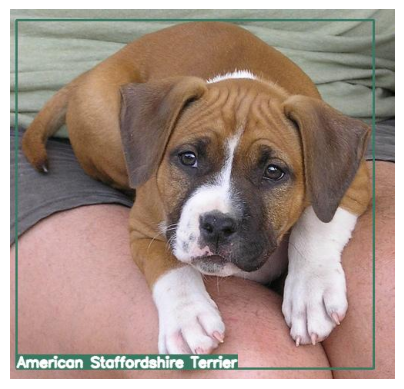

In [21]:
slide_name = 1

result_images = []

for idx in range(len(images)):
    image = images[idx]
    boxes = all_boxes[idx]
    classes = all_classes[idx]

    result_images.append(render_results(image, boxes, classes))

image_slider(result_images, slide_name=slide_name)

result_images = None

## Model

#### Basic inferance

In [23]:
model_name = "yolov8n"
version = "v1"
experiment_name = f"{model_name}-{version}"
# save_dir = f"runs/train/{projext_name}"
resume = False

if resume:
    pass
    # weight = f"{save_dir}/weights/last.pt"
    # model = YOLO(weight)
    # model.train(resume=True)
    
else:
    model = YOLO(model_name)

    model.train(
        data=dataset_yaml_path, 
        epochs=EPOCHS, 
        imgsz=IMAGE_SIZE, 
        batch=BATCH_SIZE,
        device=DEVICE,
        project=PROJECT_NAME,
        
        name=experiment_name,
        
        exist_ok=True,
        patience = 10,
        )


New https://pypi.org/project/ultralytics/8.0.131 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.117 🚀 Python-3.9.13 torch-2.0.1 MPS
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/Users/vineetmahajan/Code/AI/Projects/Hello/Hello-CNN/kaggle_notebooks/Dog Breed Detection/root_dir/detection/dataset.yaml, epochs=10, patience=10, batch=2, imgsz=640, save=True, save_period=-1, cache=False, device=mps, workers=8, project=dog_breed_detection, name=yolov8n-v1, exist_ok=True, pretrained=False, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=

KeyboardInterrupt: 